<a href="https://colab.research.google.com/github/Sakina8/Image-Processing-and-Analysis-Experiments/blob/main/Lines_with_Hough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving babochka.jpg to babochka.jpg
User uploaded file "babochka.jpg" with length 69347 bytes


In [4]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [18]:
!pip3 install tqdm

In [19]:
# Optional - for showing progress bars
from tqdm.notebook import tqdm

In [40]:

img = cv2.imread('babochka.jpg')
img

array([[[213, 158,  73],
        [213, 158,  73],
        [213, 158,  73],
        ...,
        [213, 159,  74],
        [213, 159,  74],
        [213, 159,  74]],

       [[213, 158,  73],
        [213, 158,  73],
        [213, 158,  73],
        ...,
        [213, 159,  74],
        [213, 159,  74],
        [213, 159,  74]],

       [[213, 158,  73],
        [213, 158,  73],
        [213, 158,  73],
        ...,
        [213, 159,  74],
        [213, 159,  74],
        [213, 159,  74]],

       ...,

       [[218, 170,  92],
        [219, 171,  93],
        [219, 171,  93],
        ...,
        [215, 170,  83],
        [215, 170,  83],
        [215, 170,  83]],

       [[218, 170,  92],
        [219, 171,  93],
        [219, 171,  93],
        ...,
        [215, 170,  83],
        [215, 170,  83],
        [215, 170,  83]],

       [[218, 170,  92],
        [219, 171,  93],
        [219, 171,  93],
        ...,
        [215, 170,  83],
        [215, 170,  83],
        [215, 170,  83]]

In [41]:

img.shape


(720, 1280, 3)

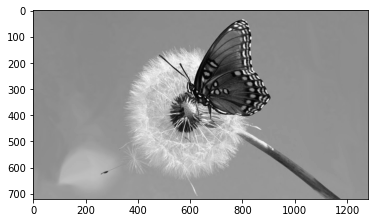

In [42]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_ = plt.imshow(gray, cmap='gray')

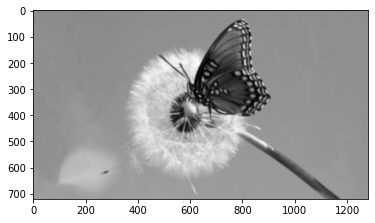

In [43]:
kernel_size = (19, 19)
sigma = 2
blurred = cv2.GaussianBlur(gray, kernel_size, sigma)
_ = plt.imshow(blurred, cmap='gray')

True

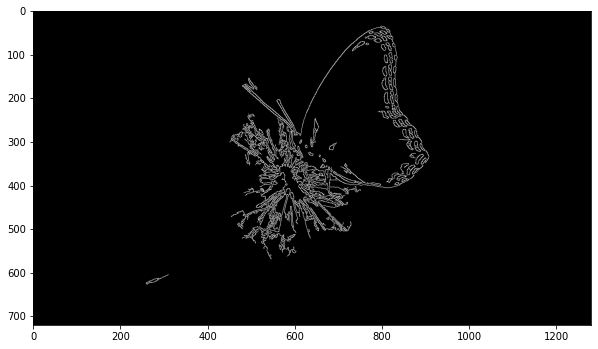

In [44]:

edges = cv2.Canny(gray, 50, 500, apertureSize=3)
plt.figure(figsize=(10, 10))
plt.imshow(edges, cmap='gray')

# Save to disk
cv2.imwrite('edgesblood.png', edges)

In [45]:
# what resolution would we like our lines to be output
# the higher the resolution the prettier the Hough accumulator image will be!
distance_resolution = 2
angular_resolution = math.pi/180.0 / 6

height, width, _ = img.shape

# the maximum possible line length
max_rho = math.sqrt(width**2 + height**2)

# the number of linear steps (+/- max rho)
num_rho = int(2 * max_rho / distance_resolution) - 1
max_rho = num_rho * distance_resolution / 2

# the number of discrete angular steps
num_theta = int(math.pi / angular_resolution)

# we make a blank "accumulator" 2d array
# each point = one line
accumulator = np.zeros((num_rho, num_theta)).astype(np.int32)
accumulator.shape

(1467, 1080)

In [46]:
# loop through each point in the image
# this is a slightly more optimised version of the above

for x in tqdm(range(0, width), desc='x'):
    for y in range(0, height):
        
        # get edge colour - will be either 0 (black), or 255 (white)
        edge_colour = edges[y, x]
        
        # if there's an edge
        if edge_colour != 0:
            
            # array of each of the discrete values of theta
            # (based on our angular resolution - from 0 to pi radians)
            theta_arr = np.arange(0, math.pi, angular_resolution)

            # solve for the corresponding rho using the line equation
            rho_arr = x * np.cos(theta_arr) + y * np.sin(theta_arr)

            # we then round each of the allowed discrete values of rho 
            # This will give us a locus of points lying approximately on a sinusoidal
            # curve for each edge point (x, y)
            rho_index_arr = np.rint(rho_arr/distance_resolution + num_rho/2).astype(np.int32)
            theta_index_arr = np.rint(theta_arr/angular_resolution).astype(np.int32)
            
            # use some numpy magic to sum matrix coordinates
            acc = np.bincount(rho_index_arr * accumulator.shape[1] + theta_index_arr)
            acc.resize(accumulator.shape)
            
            # increment by one each of the points in our accumulator matrix
            # that make up this sinusoidal curve
            accumulator += acc

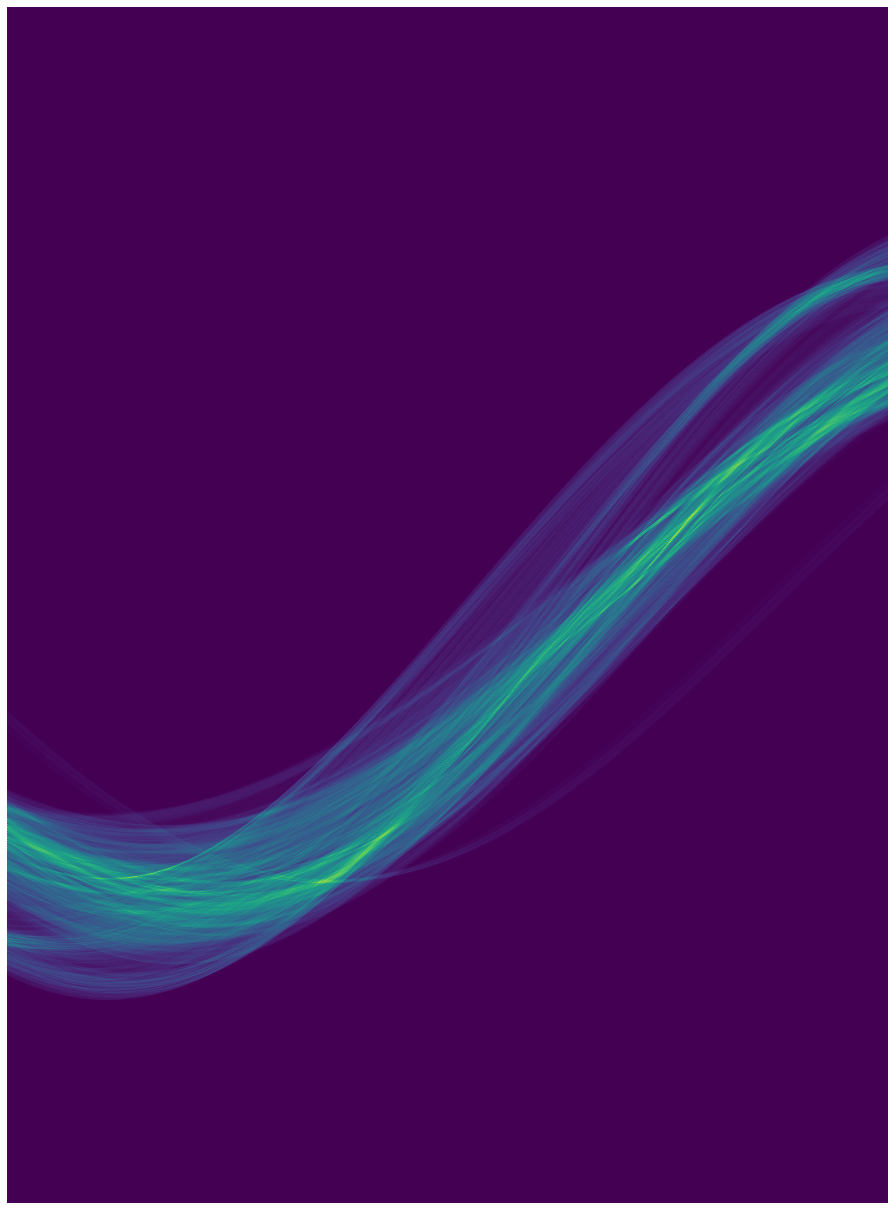

In [47]:
# Preview accumulator
# isn't it beautiful?
fig = plt.figure(figsize=(20, 22))
plt.imshow(accumulator, cmap='viridis')
plt.xlabel('theta')
plt.ylabel('rho')
plt.axis('off')
extent = fig.gca().get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('accumulator.png', bbox_inches=extent, pad_inches=0)

Text(0, 0.5, 'rho')

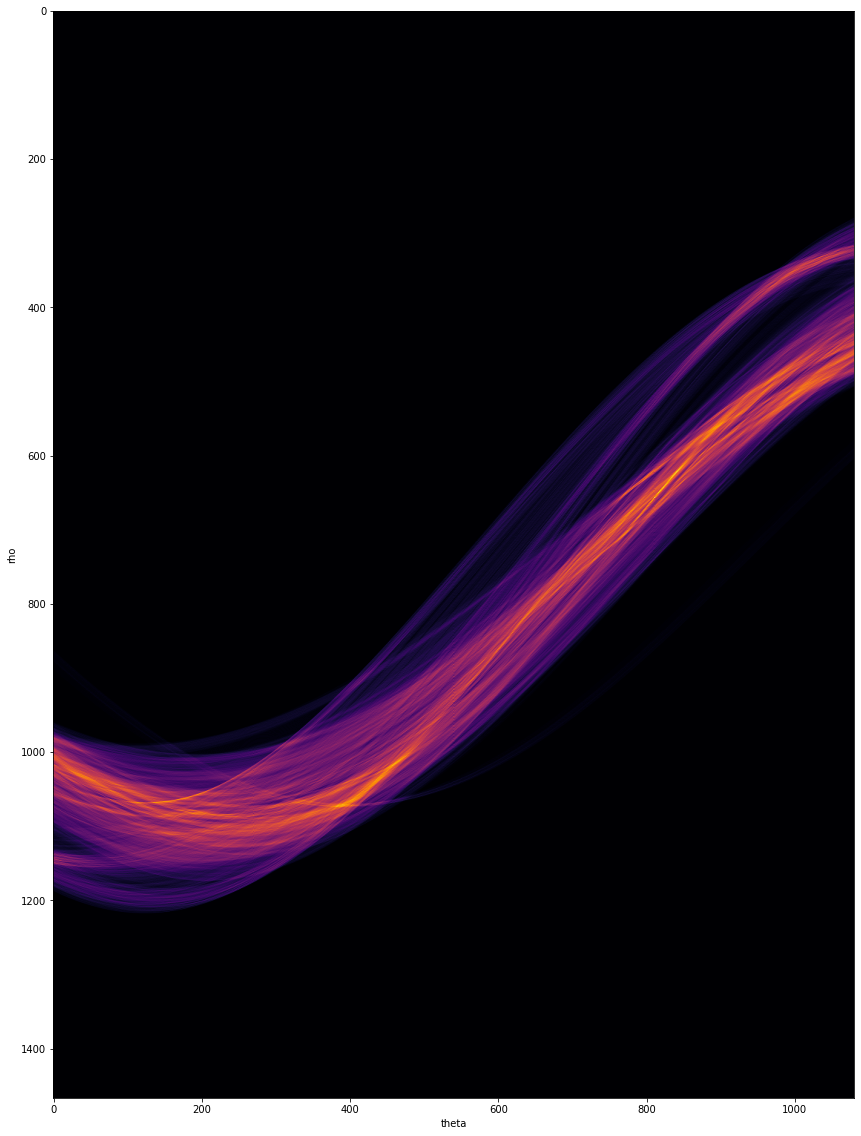

In [48]:
# Try a different colour map
plt.figure(figsize=(20, 20))
plt.imshow(accumulator, cmap='inferno')
plt.xlabel('theta')
plt.ylabel('rho')

In [49]:
# Find the rho/theta coordinate of the max point
# this will be the strongest line in our image
max_rho_index, max_theta_index = np.unravel_index(accumulator.argmax(axis=None), accumulator.shape)
(max_rho_index, max_theta_index)

(657, 811)

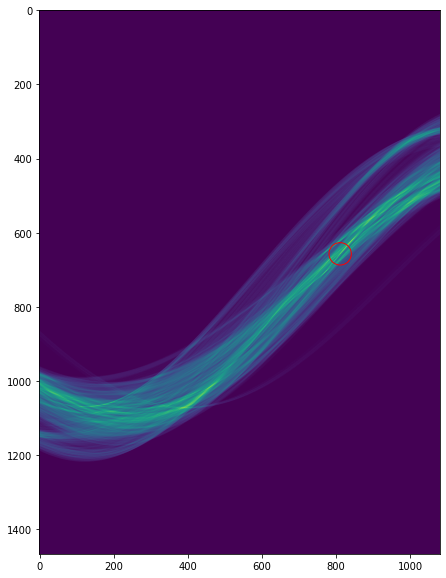

In [50]:

# circle the max point
plt.figure(figsize=(10, 10))
plt.imshow(accumulator, cmap='viridis')
_ = plt.scatter(max_theta_index, max_rho_index, 500, color='r', facecolors='none', marker='o')

In [51]:
# convert index to actual rho/theta
max_rho_val = (max_rho_index - num_rho/2) * distance_resolution
max_theta_val = max_theta_index * angular_resolution
max_rho_val, max_theta_val

(-153.0, 2.359103372279002)

In [52]:
#from polar to x/y coordinates
(x1, y1), (x2, y2) = polar_to_xy(max_rho_val, max_theta_val)
(x1, y1), (x2, y2)

((0, -217), (1280, 1070))

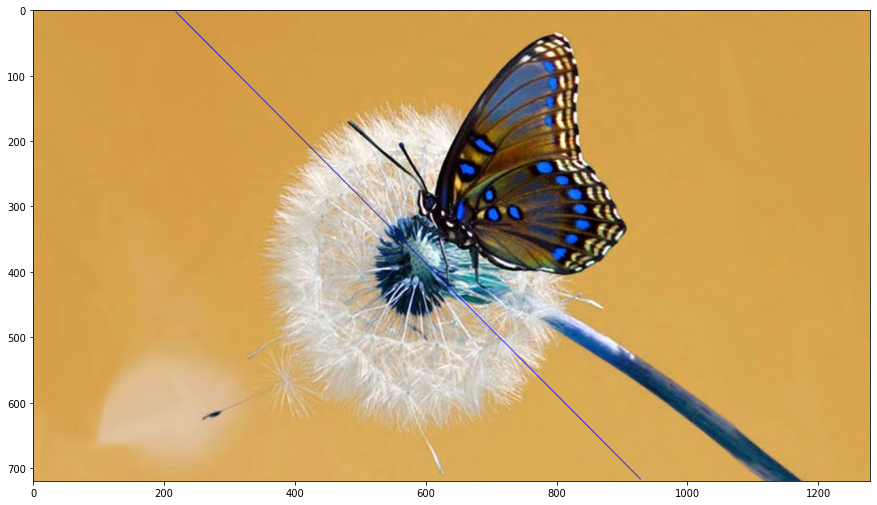

In [53]:
# draw line on image
max_line_img = img.copy()
cv2.line(max_line_img, (x1, y1), (x2, y2), red, 1, cv2.LINE_AA)
plt.figure(figsize=(15, 10))
plt.imshow(max_line_img)

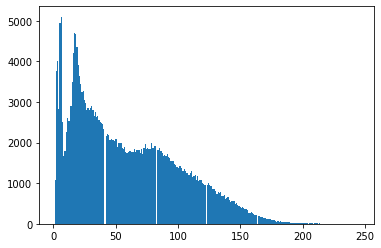

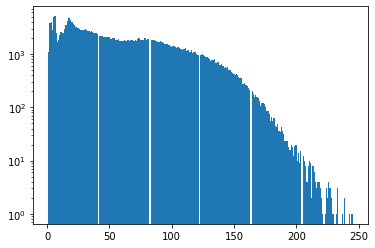

In [54]:
# Plot histogram of accumulator, to see what threshold is appropriate
flat = accumulator.flatten()
plt.figure()
plt.hist(flat[flat > 0], bins=250)
plt.figure()
plt.hist(flat[flat > 0], bins=250, log=True)
None

(650.0, 1000.0)

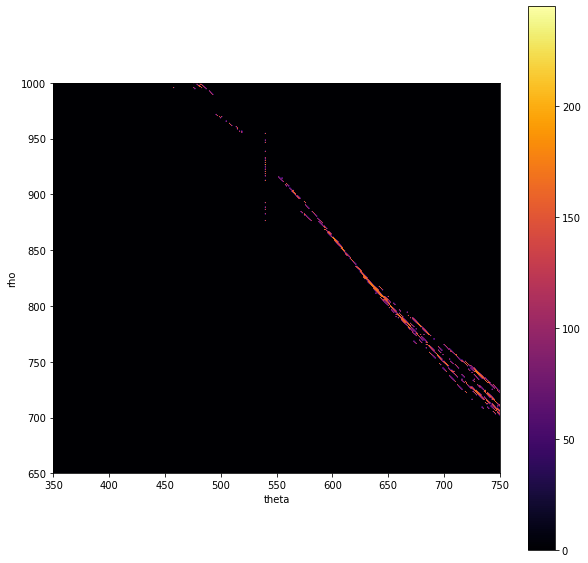

In [55]:
thresholded_accumulator = accumulator.copy()
thresholded_accumulator[thresholded_accumulator <= threshold ] = 0 # np.nan

# Preview thresholded accumulator 
plt.figure(figsize=(10, 10))
plt.imshow(thresholded_accumulator, cmap='inferno')
plt.xlabel('theta')
plt.ylabel('rho')
plt.colorbar()

# zoom in a bit (manually)
plt.xlim(350, 750)
plt.ylim(650, 1000)

In [56]:
!pip3 install scikit-image

In [57]:
# Going to use a scikit-image function to detect local peaks
# https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max
from skimage.feature import peak_local_max

In [58]:
# peaks are separated by at least min_distance
min_distance = 7
coordinates = peak_local_max(thresholded_accumulator, min_distance=min_distance)
coordinates.shape

(156, 2)

In [59]:
# first five coordinates
coordinates[:5,:]

array([[1111,  168],
       [1111,  160],
       [1109,  152],
       [1109,  150],
       [1108,  194]])

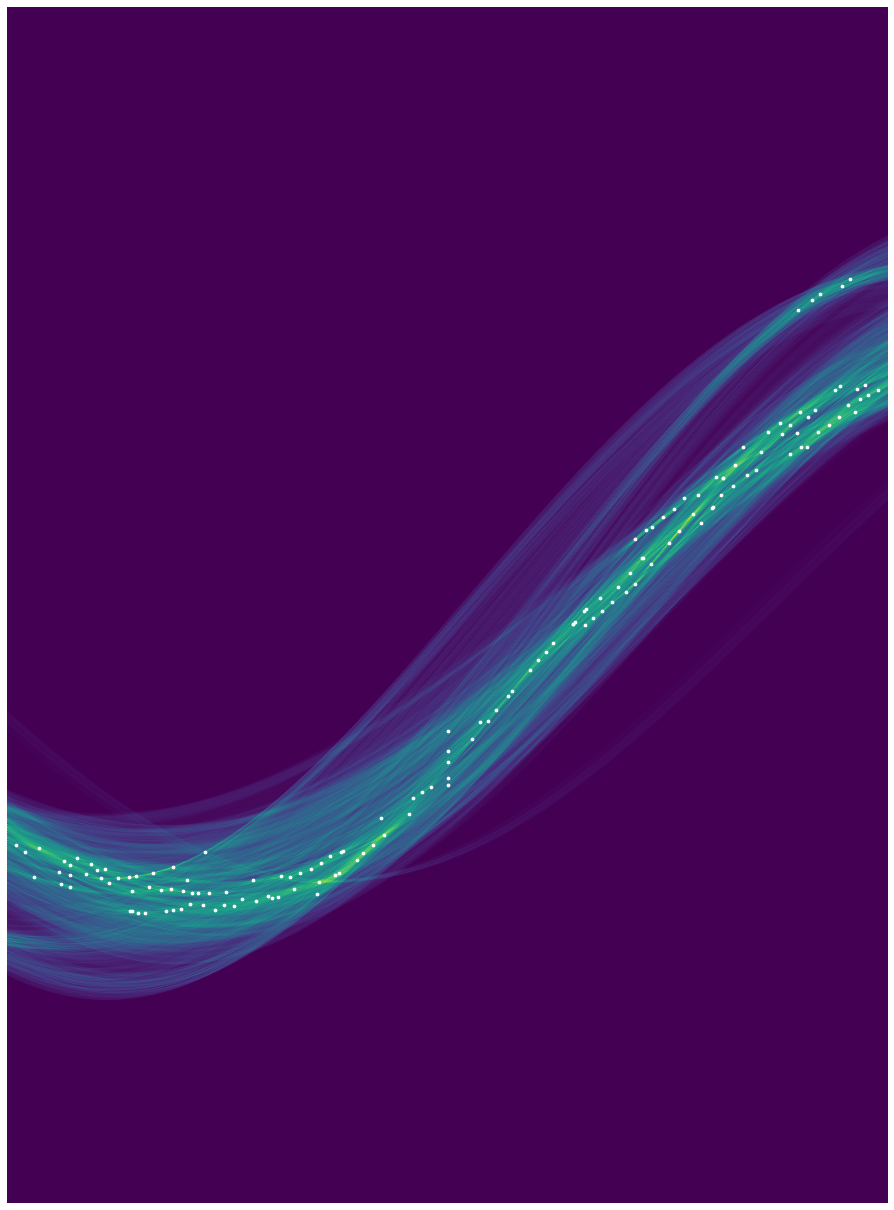

In [60]:
# circle the local peaks / maxima
fig = plt.figure(figsize=(20, 22))
plt.imshow(accumulator, cmap='viridis')
plt.axis('off')
plt.scatter(coordinates[:,1], coordinates[:,0], 30, color='w', marker='.')
extent = fig.gca().get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('accumulator_points.png', bbox_inches=extent, pad_inches=0)

True

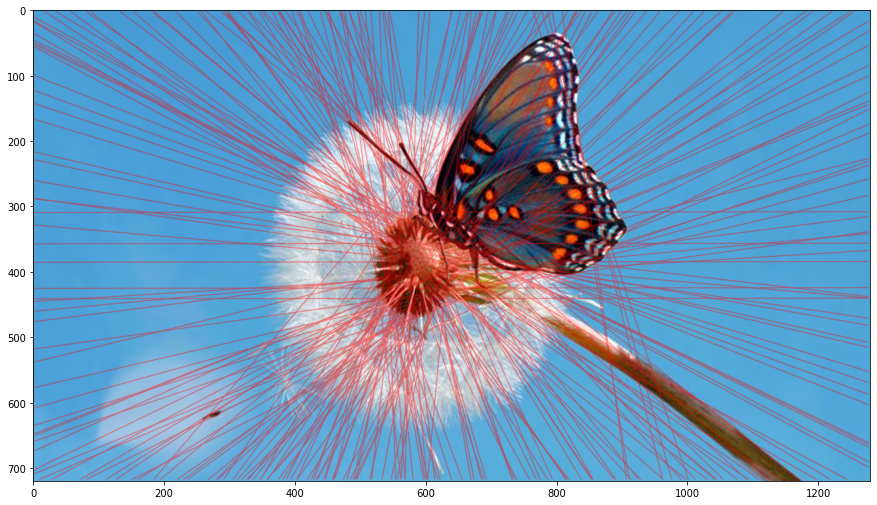

In [61]:
#Now convert all these points back to lines,
# and draw lines on a copy of the image
image_output = img.copy()

red = (0, 0, 255) # using BGR for cv2.imwrite

for rho_index, theta_index in coordinates:
    rho = (rho_index - num_rho/2) * distance_resolution
    theta = theta_index * angular_resolution
#     print((rho_index, theta_index), (rho, theta))
    (x1, y1), (x2, y2) = polar_to_xy(rho, theta)
    cv2.line(image_output, (x1, y1), (x2, y2), red, 1, cv2.LINE_AA)

# 50% "transparency" lines
image_output = cv2.addWeighted(img.copy(), 0.5, image_output, 0.5, 1)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(image_output, cv2.COLOR_RGB2BGR)) # expects RGB not BGR
cv2.imwrite('output.png', image_output) # write as BGR